# Transfer Learning



In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


In [2]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [3]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [4]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
print(contents)
classes = [each for each in contents if os.path.isdir(data_dir + each)]
print(classes)

['dandelion', 'roses', 'tulips', 'daisy', 'sunflowers', 'LICENSE.txt']
['dandelion', 'roses', 'tulips', 'daisy', 'sunflowers']


In [5]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    # TODO: Build the vgg network here
    vgg = vgg16.Vgg16()
    
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    
    vgg.build(input_)
        
       

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                
                # TODO: Get the values from the relu6 layer of the VGG network
                
                codes_batch = sess.run(vgg.relu6, feed_dict={input_: images})
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/shaodi/Desktop/AI/udacity/deep-learning-master/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting dandelion images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 ima

In [91]:
#print(labels)
print(images.shape)
print(codes)


(9, 224, 224, 3)
[[  0.           0.           2.65050507 ...,   0.           0.           0.        ]
 [  0.10668361   0.           0.         ...,   0.           5.53218842
    8.04395485]
 [  0.           1.7295295    7.9146533  ...,   0.           0.           2.6795671 ]
 ..., 
 [  0.          11.35749817   0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           7.83144855
    0.        ]
 [  0.           4.53016138   5.54387236 ...,   0.           0.           1.1811837 ]]


In [7]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

In [8]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [92]:
print(codes.shape)

(3670, 4096)


In [10]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)
 # Your one-hot encoded labels array here

print(labels_vecs)

[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ..., 
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]


In [58]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
#for train_index, test_index in sss.split(codes,labels)
 #   train_x, train_y = codes[train_index], labels_vecs[test_index]
 #   val_x, val_y = codes[train_index], labels_vecs[test_index]
 #   test_x, test_y =  codes[train_index], labels_vecs[test_index]
    
train_idx, val_idx = next(ss.split(codes, labels))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [59]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


In [69]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

# TODO: Classifier layers and operations

layer = tf.contrib.layers.fully_connected(inputs_,256)
logits = tf.contrib.layers.fully_connected(layer,5, activation_fn=None)


cost = tf.nn.softmax_cross_entropy_with_logits(labels=labels_,logits=logits)
cost = tf.reduce_mean(cost)
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
print(labels_vecs.shape[1])

5


In [67]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

In [68]:
epochs = 10
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10 Iteration: 0 Training loss: 7.76518
Epoch: 1/10 Iteration: 1 Training loss: 17.13159
Epoch: 1/10 Iteration: 2 Training loss: 27.53461
Epoch: 1/10 Iteration: 3 Training loss: 12.34878
Epoch: 1/10 Iteration: 4 Training loss: 6.51294
Epoch: 0/10 Iteration: 5 Validation Acc: 0.5150
Epoch: 1/10 Iteration: 5 Training loss: 5.48280
Epoch: 1/10 Iteration: 6 Training loss: 3.15412
Epoch: 1/10 Iteration: 7 Training loss: 2.51568
Epoch: 1/10 Iteration: 8 Training loss: 2.43613
Epoch: 1/10 Iteration: 9 Training loss: 2.11550
Epoch: 0/10 Iteration: 10 Validation Acc: 0.7275
Epoch: 2/10 Iteration: 10 Training loss: 1.11490
Epoch: 2/10 Iteration: 11 Training loss: 1.11131
Epoch: 2/10 Iteration: 12 Training loss: 1.34199
Epoch: 2/10 Iteration: 13 Training loss: 0.69431
Epoch: 2/10 Iteration: 14 Training loss: 0.81598
Epoch: 1/10 Iteration: 15 Validation Acc: 0.7548
Epoch: 2/10 Iteration: 15 Training loss: 0.81293
Epoch: 2/10 Iteration: 16 Training loss: 1.18562
Epoch: 2/10 Iteration: 17 Tr

In [74]:
epochs = 50


saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epc in range(epochs):
        for x,y in get_batches(train_x, train_y,n_batches=10):
            sess.run(optimizer, feed_dict={inputs_:x,labels_:y})
            loss = sess.run(cost, feed_dict={inputs_:x,labels_:y})
            val_acc = sess.run(accuracy, feed_dict={inputs_:x,labels_:y})
            #print("Training loss: {}".format(loss))
            print("Training loss: {:.5f}".format(loss),
                 "Validation Acc: {:.4f}".format(val_acc))
    # TODO: Your training code here
    saver.save(sess, "checkpoints/flowers.ckpt")

Training loss: 13.41092 Validation Acc: 0.4573
Training loss: 14.31905 Validation Acc: 0.5119
Training loss: 8.14773 Validation Acc: 0.5563
Training loss: 6.06765 Validation Acc: 0.6519
Training loss: 2.64502 Validation Acc: 0.7543
Training loss: 3.54678 Validation Acc: 0.6485
Training loss: 4.62330 Validation Acc: 0.5427
Training loss: 3.41238 Validation Acc: 0.6655
Training loss: 2.11613 Validation Acc: 0.7031
Training loss: 1.54819 Validation Acc: 0.7793
Training loss: 0.98727 Validation Acc: 0.8532
Training loss: 0.87797 Validation Acc: 0.8294
Training loss: 0.96078 Validation Acc: 0.7816
Training loss: 0.76831 Validation Acc: 0.8328
Training loss: 0.85775 Validation Acc: 0.8157
Training loss: 1.15385 Validation Acc: 0.8259
Training loss: 0.77498 Validation Acc: 0.8157
Training loss: 0.88059 Validation Acc: 0.8157
Training loss: 0.61455 Validation Acc: 0.8669
Training loss: 0.72521 Validation Acc: 0.8495
Training loss: 0.32214 Validation Acc: 0.9113
Training loss: 0.26990 Validatio

Training loss: 0.00494 Validation Acc: 1.0000
Training loss: 0.00589 Validation Acc: 1.0000
Training loss: 0.00714 Validation Acc: 1.0000
Training loss: 0.00517 Validation Acc: 1.0000
Training loss: 0.01091 Validation Acc: 1.0000
Training loss: 0.00805 Validation Acc: 1.0000
Training loss: 0.00696 Validation Acc: 1.0000
Training loss: 0.00644 Validation Acc: 1.0000
Training loss: 0.00482 Validation Acc: 1.0000
Training loss: 0.00975 Validation Acc: 1.0000
Training loss: 0.00456 Validation Acc: 1.0000
Training loss: 0.00534 Validation Acc: 1.0000
Training loss: 0.00648 Validation Acc: 1.0000
Training loss: 0.00470 Validation Acc: 1.0000
Training loss: 0.00989 Validation Acc: 1.0000
Training loss: 0.00721 Validation Acc: 1.0000
Training loss: 0.00634 Validation Acc: 1.0000
Training loss: 0.00579 Validation Acc: 1.0000
Training loss: 0.00441 Validation Acc: 1.0000
Training loss: 0.00875 Validation Acc: 1.0000
Training loss: 0.00416 Validation Acc: 1.0000
Training loss: 0.00485 Validation 

Training loss: 0.00155 Validation Acc: 1.0000
Training loss: 0.00302 Validation Acc: 1.0000
Training loss: 0.00202 Validation Acc: 1.0000
Training loss: 0.00210 Validation Acc: 1.0000
Training loss: 0.00175 Validation Acc: 1.0000
Training loss: 0.00146 Validation Acc: 1.0000
Training loss: 0.00263 Validation Acc: 1.0000
Training loss: 0.00144 Validation Acc: 1.0000
Training loss: 0.00161 Validation Acc: 1.0000
Training loss: 0.00199 Validation Acc: 1.0000
Training loss: 0.00148 Validation Acc: 1.0000
Training loss: 0.00287 Validation Acc: 1.0000
Training loss: 0.00191 Validation Acc: 1.0000
Training loss: 0.00200 Validation Acc: 1.0000
Training loss: 0.00166 Validation Acc: 1.0000
Training loss: 0.00139 Validation Acc: 1.0000
Training loss: 0.00250 Validation Acc: 1.0000
Training loss: 0.00137 Validation Acc: 1.0000
Training loss: 0.00153 Validation Acc: 1.0000
Training loss: 0.00190 Validation Acc: 1.0000
Training loss: 0.00141 Validation Acc: 1.0000
Training loss: 0.00272 Validation 

In [75]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.8638


In [76]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

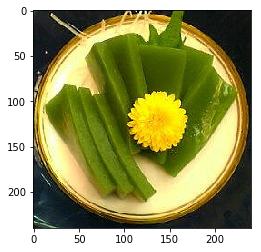

In [84]:
test_img_path = 'flower_photos/dandelion/7355522_b66e5d3078_m.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [85]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [86]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


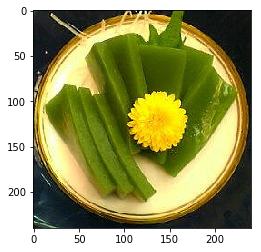

In [87]:
plt.imshow(test_img)

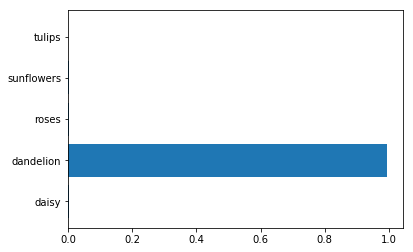

In [88]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)